In [4]:
import requests
import folium
import pandas as pd
from folium.features import GeoJsonPopup
import json
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

mpl.style.use('ggplot')

print("Modules loaded.")

Modules loaded.


In [9]:
#if you want to reproduce this work, you should be running folium v0.11.0
print(folium.__version__)

0.11.0


<b>Load the contents of the GEOJson file as a string, then process it, extract the neighborhoods and create a "center" for each neighborhood by averaging the min/max values for latitude and longitude, and put the results into a pandas dataframe.

In [5]:
stpetefile = open('stpete.geojson','r')
stpete = json.load(stpetefile)

neighborhoods=[]
centlats=[]
centlongs=[]
#THIS IS A LOOP THAT FINDS THE CENTER OF EACH NEIGHBORHOOD
for place in stpete['features']:
    latmin = None
    latmax = None
    longmin = None
    longmax = None
    for latlong in place['geometry']['coordinates'][0]:
        if latmin == None or latlong[1] < latmin:
            latmin = latlong[1]
        if latmax == None or latlong[1] > latmax:
            latmax = latlong[1]
        if longmin == None or latlong[0] < longmin:
            longmin = latlong[0]
        if longmax == None or latlong[0] > longmax:
            longmax = latlong[0]
    centlat = (latmin + latmax)/2
    centlong = (longmin + longmax)/2
    neighborhoods.append(place['properties']['Name'])
    centlats.append(centlat)
    centlongs.append(centlong)
    
df = pd.DataFrame({'Neighborhood': neighborhoods, 'centerlat': centlats, 'centerlong': centlongs})
df.head()

,Neighborhood,centerlat,centerlong
0,Pinellas Point,27.706842,-82.660546
1,Wildwood Heights,27.758676,-82.667071
2,Sunset Drive South,27.768898,-82.743095
3,Brighton Bay,27.876057,-82.626393
4,Barclay Estates,27.852065,-82.651044


<b>Let's use Folium to visualize both the neighborhood boundaries from the GEOJson file as well as the centerpoints of each neighborhood that we have created.

In [17]:
#initialize map
world_map = folium.Map(location=[27.79,-82.66], zoom_start=11, tiles='OpenStreetMap')
choropleth = folium.Choropleth(
    geo_data=stpete,
    highlight=True,
    fill_opacity=0.7, 
    line_opacity=0.2,
).add_to(world_map)

#loop through neighborhoods dataframe and add a marker for the center of each neighborhood
for neigh, lat, lng, in zip(df.Neighborhood, df.centerlat, df.centerlong):
    world_map.add_child(
        folium.Circle(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6,
            popup=neigh
        )
    )

#stylize the visual to look nicer and add mouseover tooltips to display neighborhood names
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
NIL = folium.features.GeoJson(
    stpete,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['Name'],
        labels=False,
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
world_map.add_child(NIL)
world_map.keep_in_front(NIL)
folium.LayerControl().add_to(world_map)
world_map

<B>Let's prepare to receive the Foursquare location data for each neighborhood by writing a function to get venues(NOTE: Please enter your own Client ID and Secret if you'd like to run this code):

In [5]:
#Define function to get results for a given neighborhood center and queries; define a new dataframe to store the results
def get_data(queries, lats, longs):
    CLIENT_ID = ' ' 
    CLIENT_SECRET = ' ' 
    VERSION = '20200605' 
    LIMIT=500
    lat=lats
    lng=longs
    radius=800
    query=queries
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            query)
    results = requests.get(url).json()
    return results

<B>Now call the function for each combination of neighborhood and queries. Check the lat/long for each returned venue against a list of venues already stored, and save non-duplicates in list "venues":

In [67]:
#we set our queries in a list and then loop through the queries for each neighborhood, compiling a list of venues returned.
#we recognize that a venue may be returned via more than one search given that some neighborhoods are close to each other
#to prevent duplicates, we set a filter and only append venues that do not already exist in our list
queries = ["Restaurant", "IceCream", "Park", "School"]
venues = []
existing = []
for hood in df.index.values:
    for quer in queries:
        results = get_data(quer, df.loc[hood, 'centerlat'], df.loc[hood, 'centerlong'])
        try:
            for venue in results['response']['groups'][0]['items']:
                try:
                    name = venue['venue']['name']
                    category = venue['venue']['categories'][0]['name']
                    latitude = venue['venue']['location']['lat']
                    longitude = venue['venue']['location']['lng']
                    if (latitude,longitude) not in existing:
                        existing.append((latitude, longitude))
                        venues.append([df.loc[hood, 'Neighborhood'], df.loc[hood, 'centerlat'], df.loc[hood, 'centerlong'], name, latitude, longitude, category, quer])
                except:
                    pass       
        except:
            pass

<B>Convert the raw data to a Pandas dataframe and see how many raw results were returned:

In [68]:
df3 = pd.DataFrame(venues)
columns = ['Neighborhood', 'NLat', 'NLong', 'Venue', 'VenueLat', 'VenueLong', 'Category', 'Type']
df3.columns = columns
df3.tail()

,Neighborhood,NLat,NLong,Venue,VenueLat,VenueLong,Category,Type
681,Lake Maggiore Shores,27.744828,-82.654747,Dell Holmes Park,27.742501,-82.661449,Scenic Lookout,Park
682,Highland Oaks,27.747298,-82.669067,"Mike ""The Bar B Cue Man""",27.747770,-82.668141,BBQ Joint,Restaurant
683,Highland Oaks,27.747298,-82.669067,Title I Office,27.745640,-82.667556,School,School
684,Highland Oaks,27.747298,-82.669067,Lakeview Fundamental,27.746626,-82.668320,Elementary School,School
685,Isla Del Sol,27.705887,-82.714830,Fort Desoto Dog Park,27.712330,-82.714616,Dog Run,Park


<B> Begin inspecting the data. Review categories and venue names and compile a list of those we are uninterested in to drop from the dataset.

In [15]:
#Explore Foursquare result categories and drop any that made it through the search but do not fit our filters
#Automotive Shop, Bagel Shop, Breakfast Spot, Church, Cocktail Bar, Daycare, Doctor's Office, Driving School, Gas Station
#Gay Bar, Gym, Intersection, Irish Pub, Library, Liquor Store, Neighborhood, Nursery School, Office, Pet Service, Trade School,
#Veterinarian, Fast Food Restaurant
x = df3.groupby(['Category']).count()
pd.set_option('display.max_rows', 500)
x.head()

,Unnamed: 0,Neighborhood,NLat,NLong,Venue,VenueLat,VenueLong,Type
Category,,,,,,,,
American Restaurant,32,32,32,32,32,32,32,32
Asian Restaurant,5,5,5,5,5,5,5,5
BBQ Joint,13,13,13,13,13,13,13,13
Baiano Restaurant,1,1,1,1,1,1,1,1
Bakery,12,12,12,12,12,12,12,12


<B>Drop bad results from the dataframe and see how many venues we are left with:

In [70]:
#Drop the results we're not interested in from the dataframe

dropcats = ['Automotive Shop', 'Bagel Shop', 'Breakfast Spot', 'Church', 'Cafeteria' 'Cocktail Bar', 'Daycare', "Doctor's Office", 'Driving School', 'Gas Station', 'Gay Bar', 'Gym', 'Intersection', 'Irish Pub', 'Library', 'Liquor Store', 'Neighborhood', 'Nursery School', 'Office', 'Pet Service', 'Trade School', 'Veterinarian', 'Fast Food Restaurant']
dropnames = ["McDonald's", "Domino's Pizza", "SUBWAY", "Subway" "Pizza Hut", "KFC", "Bob Evans Restaurant", "Chipotle Mexican Grill", "Dunkin'", "Hungry Howie's Pizza", "Jimmy John's", "Panera Bread", "Papa John's Pizza"]
for cat in dropcats:
    df3.drop(df3[df3['Category'] == cat].index, inplace = True)
for name in dropnames:
    df3.drop(df3[df3['Venue'] == name].index, inplace = True)
df3.shape

(582, 8)

<B>There is also some neighborhood mis-classification. In particular, we fill fix Grand Central District. Due to its odd size, almost all of the results within it were classified to the wrong neighborhood. We will inspect all venues by lat/long and those that fall within the bounds of Grand Central will be reclassified.

In [162]:
#There is some mis-classification here. Most of it should be OK for the purposes of our analysis
#But Grand Central District is a particular problem given its size and shape, so we will fix the classifications of venues within it. 
#It's lat/long bounds are: Grand Central District 27.770102274706 27.7720014467825 -82.6740009406898 -82.6548123066101
latmin = 27.770102274706
latmax = 27.7720014467825
longmin = -82.6548123066101
longmax = -82.6740009406898
reclassify = []
for index, venue, lat, long in zip(df3['Venue'].index.values, df3['Venue'].values, df3['VenueLat'].values, df3['VenueLong'].values):
    if (latmin < lat < latmax) and (longmax < long < longmin):
        reclassify.append(index)
for idno in reclassify:        
    df3.at[idno, 'Neighborhood'] = "Grand Central District"


'Grand Central District'

<B>Now for some exploratory analysis. Let's visualize the total number of venues by type:

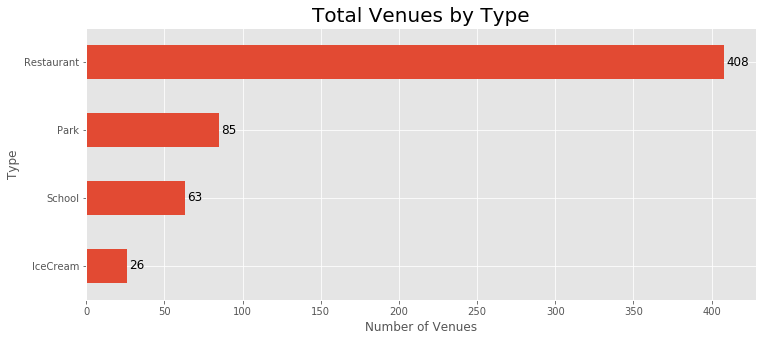

In [109]:
#Now let's look at total venues by type

typ = df3.groupby(['Type']).count()
typ
typ.drop(['NLat', 'NLong', 'Venue', 'VenueLat', 'VenueLong', 'Category'], axis=1, inplace=True)
typ.sort_values(by='Neighborhood', ascending=True, inplace=True)

ax = typ.plot(kind='barh', figsize=(12,5))
ax.set_title("Total Venues by Type", size=20)
ax.set_xlabel('Number of Venues', size=12)
ax.get_legend().remove()
for i, value in enumerate(typ['Neighborhood']):
    ax.annotate(str(value), xy=(value+1.5, i+-.05), color='black', size=12)

<B>As well as the total venues by neighborhood:

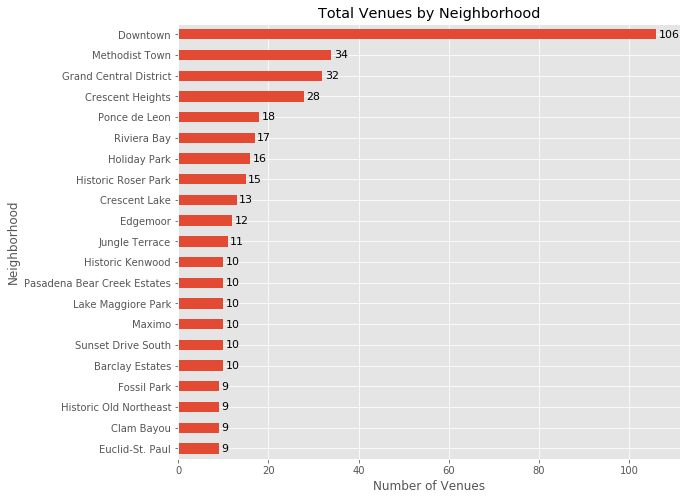

In [227]:
#create a dataframe with the total number of venues by neighborhood to be graphed; filter so that we only see neighborhoods
#with 5 or more total venues to make the graph more manageable to look at. Then display a bar graph.

bar = df3.groupby(['Neighborhood']).count()
bar.drop(['NLat', 'NLong', 'Venue', 'VenueLat', 'VenueLong', 'Category'], axis=1, inplace=True)
bar.sort_values(by='Type', ascending=True, inplace=True)
mostvenuesorder = bar.index.values #let's save this order of the rows to use for the next graph
bar = bar[bar['Type'] > 8]

ax = bar.plot(kind='barh', figsize=(9,8), label="Number of Total Venues by Neighborhood")
ax.set_title("Total Venues by Neighborhood")
ax.set_xlabel('Number of Venues')
ax.get_legend().remove()
for i, value in enumerate(bar['Type']):
    ax.annotate(str(value), xy=(value+.5, i-.15), color='black', size=11)

<B> One more important factor in our analysis will be the ice cream shop to restaurant ratio, so let's visualize that as well and keep it in the order of most total venues to look for opportunities:

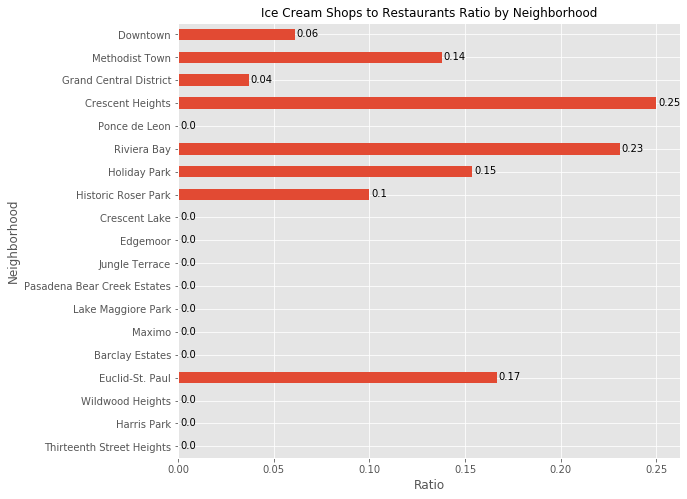

In [243]:
#Let's look at the ice cream to restaurant ratio by neighborhood. We'll drop any neighborhood that has fewer than 5 restaurants.
types = df3[['Type']]
multidum = pd.get_dummies(types['Type'])
combined = pd.concat([df3['Neighborhood'], multidum], axis=1) 
combined = combined.groupby(['Neighborhood']).sum()
combined.rename(columns={'IceCream':'Ice Cream'}, inplace=True)
combined2 = combined.reindex(mostvenuesorder)
combined2
combined2.drop(combined2[combined2['Restaurant'] < 6].index, inplace = True)
combined2['Ice Cream Shops to Restaurants Ratio'] = combined2['Ice Cream'] / combined2['Restaurant']
combined2.drop(['Ice Cream', 'Park', 'Restaurant', 'School'], axis=1, inplace=True)

ax = combined2.plot(kind='barh', figsize=(9,8))
ax.set_title("Ice Cream Shops to Restaurants Ratio by Neighborhood", size=12)
ax.set_xlabel('Ratio', size=12)
ax.get_legend().remove()
for i, value in enumerate(combined2['Ice Cream Shops to Restaurants Ratio']):
    ax.annotate(str(round(value, 2)), xy=(value+.001, i-.11), color='black', size=10)

<B>Finally, let's run K-Means clustering to see where else there may be opportunities:

In [208]:
#create dataframes for clustering analysis
types = df3[['Type']]
multidum = pd.get_dummies(types['Type'])
cluster = pd.concat([df3['Neighborhood'], multidum], axis=1) 
cluster = cluster.groupby(['Neighborhood']).sum()
cluster.rename(columns={'IceCream':'Ice Cream'}, inplace=True)

runclusters = cluster.copy()
runclusters.reset_index(inplace=True)
runclusters.drop(['Neighborhood'], axis=1, inplace=True)

kmeans = KMeans(n_clusters=4, random_state=0).fit(runclusters)

# add clusters back into the original dataframe
cluster['Cluster'] = kmeans.labels_
cluster.reset_index(inplace=True)
cluster

,Neighborhood,Ice Cream,Park,Restaurant,School,Cluster
0,Allendale Terrace,0,2,5,0,0
1,Americana Cove,0,2,2,0,0
2,Azalea Homes,0,1,2,3,0
3,Bahama Shores,0,1,1,0,0
4,Barclay Estates,0,0,9,1,3
5,Bartlett Park,1,1,4,2,0
6,Bayway Isles,0,0,2,0,0
7,Broadwater,0,0,1,0,0
8,Casler Heights,0,0,0,2,0
9,Causeway Isles,0,1,1,0,0


<B>Let's inspect the clusters one at a time so that we can classify them:

In [209]:
#cluster 0
cluster.loc[cluster['Cluster'] == 0]

,Neighborhood,Ice Cream,Park,Restaurant,School,Cluster
0,Allendale Terrace,0,2,5,0,0
1,Americana Cove,0,2,2,0,0
2,Azalea Homes,0,1,2,3,0
3,Bahama Shores,0,1,1,0,0
5,Bartlett Park,1,1,4,2,0
6,Bayway Isles,0,0,2,0,0
7,Broadwater,0,0,1,0,0
8,Casler Heights,0,0,0,2,0
9,Causeway Isles,0,1,1,0,0
10,Central Oak Park,1,1,1,0,0


<B>Cluster 0 is quite large and appears to be largely residential. No neighborhoods in the cluster have more than 6 restaurants. Let's look at cluster 1:

In [210]:
cluster.loc[cluster['Cluster'] == 1]

,Neighborhood,Ice Cream,Park,Restaurant,School,Cluster
18,Downtown,5,16,82,3,1


<B>Cluster 1 consists only of Downtown. This makes sense as Downtown is uniquely dense. 

In [211]:
cluster.loc[cluster['Cluster'] == 2]

,Neighborhood,Ice Cream,Park,Restaurant,School,Cluster
14,Crescent Heights,5,3,20,0,2
27,Grand Central District,1,0,27,4,2
49,Methodist Town,4,0,29,1,2


<B>Cluster 2 is a downtown-adjacent cluster, each neighborhood with many restaurants and most with several ice cream shops. Grand Central District looks like it could be a good opportunity for us as it only has one ice cream shop but 27 restaurants.

In [212]:
cluster.loc[cluster['Cluster'] == 3]

,Neighborhood,Ice Cream,Park,Restaurant,School,Cluster
4,Barclay Estates,0,0,9,1,3
15,Crescent Lake,0,2,11,0,3
21,Edgemoor,0,0,7,5,3
36,Historic Roser Park,1,3,10,1,3
38,Holiday Park,2,0,13,1,3
46,Maximo,0,1,9,0,3
56,Pasadena Bear Creek Estates,0,0,9,1,3
61,Ponce de Leon,0,0,17,1,3
62,Riviera Bay,3,1,13,0,3


<B>Cluster 3 appears to be a hybrid residential cluster, with neighborhoods that have a moderate amount of restaurants. Some of these could represent moderate opportunities.
    
Finally, let's visualize all of our venues onto one interactive map:

In [163]:
#visualize all venues by plotting them on top of our neighborhoods map
world_map = folium.Map(location=[27.7,-82.66], zoom_start=11, tiles='OpenStreetMap')
choropleth = folium.Choropleth(
    geo_data=stpete,
    highlight=True,
    fill_opacity=0.7, 
    line_opacity=0.2,
).add_to(world_map)

#loop through venues dataframe and add a marker for each venue. colorize by type.

style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
NIL = folium.features.GeoJson(
    stpete,
    style_function=style_function, 
    control=False,
    tooltip=folium.features.GeoJsonTooltip(
        fields=['Name'],
        labels=False,
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
world_map.add_child(NIL)
folium.LayerControl().add_to(world_map)

for neigh, ven, lat, lng, typ in zip(df3.Neighborhood, df3.Venue, df3.VenueLat, df3.VenueLong, df3.Type):
    if typ == "IceCream":
        clr = 'red'
    elif typ == "Park":
        clr = 'lightgreen'
    elif typ == "Restaurant":
        clr = 'yellow'
    else:
        clr = 'orange'
    world_map.add_child(
        folium.Circle(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color=clr,
            fill=True,
            fill_color=clr,
            fill_opacity=0.6,
            popup=[neigh, ven]
        )
    )
world_map